# Requirements

The API keys are not included in the code as instructed

In [1]:
from google.colab import userdata
pexels_key=userdata.get('pexels_key')
gemini_key=userdata.get('gemini_key')
pinecone_key=userdata.get('pinecone_key')

In [2]:
!pip install clip
!pip install transformers torch torchvision pillow
!pip install pinecone-client transformers torch torchvision pillow

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=680ee89457e1fc12d04a7d431aaf7d3298561b0903c4e5463a3aabb2f8275d6d
  Stored in directory: /root/.cache/pip/wheels/ab/a5/e8/c9fa20742edbccf2702dae8ee62053e6c460e961d45967b49c
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

CLIP and BLIP models are introduced

The role of the Open AI Clip model is to convert images and text into embeddings

The role of the blip model is like an llm which is generating a context/small descrition as a high level meta data for the image

In [3]:
from transformers import CLIPModel, CLIPProcessor, BlipProcessor, BlipForConditionalGeneration

# Load CLIP Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load BLIP Model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

# Uploading Step

Here, the input is processed and then searched across the web through Pexels platform, conatining about 100 millions of images

If the input is text it is passed straight to the pexel search api

If the input is image, firstly it is passed to the Blip model for getting a context of the image and then it is passed into the Pexel search API

In [4]:
import os
import requests
from PIL import Image
from io import BytesIO

class PexelsImageFetcher:
    # Handles fetching images from Pexels based on a search query
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.pexels.com/v1/search"
        self.headers = {"Authorization": self.api_key}

    def search_images(self, query, num_images=100):
        # Search for images on Pexels using a query and return a list of image URLs
        params = {"query": query, "per_page": num_images}
        response = requests.get(self.base_url, headers=self.headers, params=params)
        if response.status_code == 200:
            results = response.json()
            return [photo["src"]["original"] for photo in results.get("photos", [])]
        else:
            print(f"❌ Pexels API error: {response.status_code}")
            return []

class ImageProcessor:
    # Handles image processing tasks like description generation using BLIP
    def __init__(self, blip_model, blip_processor):
        self.blip_model = blip_model
        self.blip_processor = blip_processor

    def generate_description(self, image_path):
        # Generate a textual description of an image using BLIP
        image = Image.open(image_path).convert("RGB")
        inputs = self.blip_processor(images=image, return_tensors="pt")
        output = self.blip_model.generate(**inputs)
        return self.blip_processor.decode(output[0], skip_special_tokens=True)

class ImageDownloader:
    # Handles downloading images from URLs and saving them locally
    def __init__(self, save_dir="downloaded_images"):
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def download(self, image_urls):
        # Download images from a list of URLs and save them in the specified directory
        for i, url in enumerate(image_urls):
            try:
                response = requests.get(url, timeout=5)
                img = Image.open(BytesIO(response.content))
                img.save(f"{self.save_dir}/image_{i+1}.jpg")
                print(f"✅ Downloaded: {url}")
            except Exception as e:
                print(f"❌ Failed to download {url}: {e}")

class ImageSearchTool:
    # Main class that coordinates image fetching, processing, and downloading
    def __init__(self, pexels_key, blip_model=None, blip_processor=None):
        self.fetcher = PexelsImageFetcher(pexels_key)
        self.processor = ImageProcessor(blip_model, blip_processor) if blip_model and blip_processor else None
        self.downloader = ImageDownloader()

    def run(self, image_path=None, search_query=None):
        # Runs the image search workflow, fetching, processing, and downloading images
        image_urls = []

        if search_query:
            print("🔍 Searching images on Pexels...")
            image_urls += self.fetcher.search_images(search_query)

        if image_path and self.processor:
            print("🔍 Generating image description...")
            generated_query = self.processor.generate_description(image_path)
            print("📖 Generated Description:", generated_query)
            print("🔍 Searching images on Pexels using the generated description...")
            image_urls += self.fetcher.search_images(generated_query)

        print(f"📸 Total images found: {len(image_urls)}")
        self.downloader.download(set(image_urls))

if __name__ == "__main__":
  # Replace with actual API key
    tool = ImageSearchTool(pexels_key)
    tool.run(image_path=None, search_query="Sports")


🔍 Searching images on Pexels...
📸 Total images found: 80
✅ Downloaded: https://images.pexels.com/photos/248547/pexels-photo-248547.jpeg
✅ Downloaded: https://images.pexels.com/photos/386024/pexels-photo-386024.jpeg
✅ Downloaded: https://images.pexels.com/photos/317157/pexels-photo-317157.jpeg
✅ Downloaded: https://images.pexels.com/photos/1638051/pexels-photo-1638051.jpeg
✅ Downloaded: https://images.pexels.com/photos/551852/pexels-photo-551852.jpeg
✅ Downloaded: https://images.pexels.com/photos/1208777/pexels-photo-1208777.jpeg
✅ Downloaded: https://images.pexels.com/photos/538694/pexels-photo-538694.jpeg
✅ Downloaded: https://images.pexels.com/photos/2834917/pexels-photo-2834917.jpeg
✅ Downloaded: https://images.pexels.com/photos/863988/pexels-photo-863988.jpeg
✅ Downloaded: https://images.pexels.com/photos/341003/pexels-photo-341003.jpeg
✅ Downloaded: https://images.pexels.com/photos/1552249/pexels-photo-1552249.jpeg
✅ Downloaded: https://images.pexels.com/photos/449609/pexels-photo

# Generating high quality Meta Data

Here each of the image is passed into BLIP model

In [5]:
import os
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

class ImageCaptionGenerator:
    # Handles loading BLIP model and processing images for caption generation
    def __init__(self, blip_model, blip_processor):
        self.blip_model = blip_model
        self.blip_processor = blip_processor

    def generate_caption(self, image_path):
        # Generate a caption for the given image using BLIP
        image = Image.open(image_path).convert("RGB")
        inputs = self.blip_processor(images=image, return_tensors="pt")
        output = self.blip_model.generate(**inputs)
        return self.blip_processor.decode(output[0], skip_special_tokens=True)

class ImageCaptioningPipeline:
    # Manages image processing and caption generation workflow
    def __init__(self, image_folder, output_folder, blip_model, blip_processor):
        self.image_folder = image_folder
        self.output_folder = output_folder
        self.caption_generator = ImageCaptionGenerator(blip_model, blip_processor)
        os.makedirs(self.output_folder, exist_ok=True)

    def process_images(self):
        # Processes all images in the folder and saves captions
        for filename in os.listdir(self.image_folder):
            if filename.endswith((".jpg", ".png")):
                image_path = os.path.join(self.image_folder, filename)
                caption = self.caption_generator.generate_caption(image_path)

                output_filename = os.path.splitext(filename)[0] + ".txt"
                output_path = os.path.join(self.output_folder, output_filename)

                with open(output_path, "w") as f:
                    f.write(caption)
        print(f"Captions saved in {self.output_folder}")

if __name__ == "__main__":
    image_folder = "downloaded_images"
    output_folder = "downloaded_captions"

    pipeline = ImageCaptioningPipeline(image_folder, output_folder, blip_model, blip_processor)
    pipeline.process_images()



Captions saved in downloaded_captions


# Forming Embeddings and storing it into Vector DB

CLIP model is being called for each text and image

Both text and images are converted into 512 vector dimensions and then concatenated to form a 1024 dimension vector

An index is already made in my Pinecone DB named as image-search, all the embeddings are upserted there

In [7]:
import os
import torch
import numpy as np
from PIL import Image
from pinecone import Pinecone, ServerlessSpec
from transformers import CLIPModel, CLIPProcessor

class PineconeManager:
    def __init__(self, api_key, index_name, dimension=1024):
        self.pc = Pinecone(api_key=api_key)
        self.index_name = index_name
        # if index_name not in self.pc.list_indexes():
        #     self.pc.create_index(
        #         name=index_name,
        #         dimension=dimension,
        #         metric="cosine",
        #         spec=ServerlessSpec(cloud="aws", region="us-east-1")
        #     )
        self.index = self.pc.Index(index_name)

    def upsert_embedding(self, filename, embedding, metadata):
        existing_results = self.index.query(vector=embedding.tolist(), top_k=1, include_metadata=True)
        if existing_results["matches"]:
            self.index.delete(ids=[filename])
        self.index.upsert([(filename, embedding.tolist(), metadata)])

class ImageEmbeddingGenerator:
    def __init__(self, clip_model, clip_processor):
        self.clip_model = clip_model
        self.clip_processor = clip_processor

    def get_image_embedding(self, image_path):
        image = Image.open(image_path).convert("RGB")
        inputs = self.clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_embedding = self.clip_model.get_image_features(**inputs)
        return image_embedding.squeeze().cpu().numpy()

    def get_text_embedding(self, text):
        inputs = self.clip_processor(text=[text], return_tensors="pt")
        with torch.no_grad():
            text_embedding = self.clip_model.get_text_features(**inputs)
        return text_embedding.squeeze().cpu().numpy()

class ImageCaptionProcessor:
    def __init__(self, image_folder, caption_folder, embedding_generator, pinecone_manager):
        self.image_folder = image_folder
        self.caption_folder = caption_folder
        self.embedding_generator = embedding_generator
        self.pinecone_manager = pinecone_manager

    def process_images(self):
        for filename in os.listdir(self.image_folder):
            if filename.endswith((".jpg", ".png")):
                image_path = os.path.join(self.image_folder, filename)
                caption_path = os.path.join(self.caption_folder, os.path.splitext(filename)[0] + ".txt")

                if not os.path.exists(caption_path):
                    print(f"Skipping {filename}, caption not found.")
                    continue

                try:
                    with open(caption_path, "r") as f:
                        caption = f.read().strip()
                except Exception as e:
                    print(f"Failed to read caption for {filename}: {e}")
                    continue

                try:
                    image_embedding = self.embedding_generator.get_image_embedding(image_path)
                    text_embedding = self.embedding_generator.get_text_embedding(caption)
                except Exception as e:
                    print(f"Failed to generate embeddings for {filename}: {e}")
                    continue

                combined_embedding = np.concatenate((image_embedding, text_embedding))
                metadata = {"caption": caption, "image_path": image_path}

                try:
                    self.pinecone_manager.upsert_embedding(filename, combined_embedding, metadata)
                    print(f"Upserted {filename} to Pinecone")
                except Exception as e:
                    print(f"Failed to upsert {filename}: {e}")
        print("Embeddings stored in Pinecone successfully!")

if __name__ == "__main__":
    PINECONE_API_KEY = pinecone_key
    index_name = "image-search"
    image_folder = "downloaded_images"
    caption_folder = "downloaded_captions"

    pinecone_manager = PineconeManager(api_key=PINECONE_API_KEY, index_name=index_name)
    embedding_generator = ImageEmbeddingGenerator(clip_model, clip_processor)
    image_processor = ImageCaptionProcessor(image_folder, caption_folder, embedding_generator, pinecone_manager)

    image_processor.process_images()


Upserted image_77.jpg to Pinecone
Upserted image_25.jpg to Pinecone
Upserted image_76.jpg to Pinecone
Upserted image_39.jpg to Pinecone
Upserted image_61.jpg to Pinecone
Upserted image_13.jpg to Pinecone
Upserted image_44.jpg to Pinecone
Upserted image_79.jpg to Pinecone
Upserted image_68.jpg to Pinecone
Upserted image_2.jpg to Pinecone
Upserted image_35.jpg to Pinecone
Upserted image_37.jpg to Pinecone
Upserted image_8.jpg to Pinecone
Upserted image_36.jpg to Pinecone
Upserted image_5.jpg to Pinecone
Upserted image_53.jpg to Pinecone
Upserted image_21.jpg to Pinecone
Upserted image_55.jpg to Pinecone
Upserted image_65.jpg to Pinecone
Upserted image_33.jpg to Pinecone
Upserted image_31.jpg to Pinecone
Upserted image_1.jpg to Pinecone
Upserted image_26.jpg to Pinecone
Upserted image_69.jpg to Pinecone
Upserted image_10.jpg to Pinecone
Upserted image_47.jpg to Pinecone
Upserted image_30.jpg to Pinecone
Upserted image_16.jpg to Pinecone
Upserted image_75.jpg to Pinecone
Upserted image_15.

# Retrieving Top 5 outputs

Based on the input text or image, it is firstly passed on to the CLIP model to get embeddings

Next the embeddings are searched through the entries of Pinecone index and the top 5 embeddings based on the similarity scores are retrieved

Search by (image/text/both): image
Enter image path: /content/test_image2.jpeg


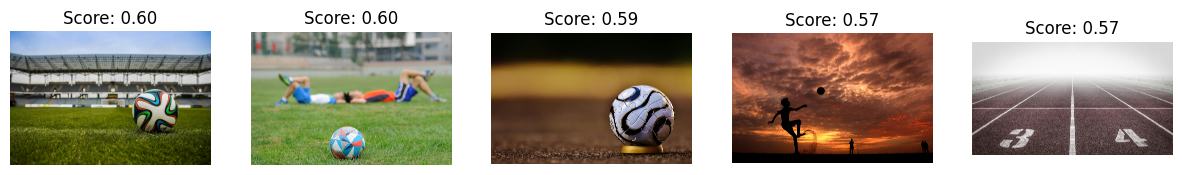

In [9]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from pinecone import Pinecone

class PineconeManager:
    # Handles interactions with the Pinecone vector database.
    def __init__(self, api_key, index_name, dimension=1024):
        self.pc = Pinecone(api_key=api_key)
        self.index_name = index_name
        self.index = self.pc.Index(index_name)

    def query_images(self, query_vector, top_k=5):
        # Queries Pinecone for the top_k most similar images.
        return self.index.query(vector=query_vector.tolist(), top_k=top_k, include_metadata=True)

class ImageEmbeddingGenerator:
    # Generates embeddings for images and text using CLIP.
    def __init__(self, clip_model, clip_processor):
        self.clip_model = clip_model
        self.clip_processor = clip_processor

    def get_image_embedding(self, image_path):
        # Computes the embedding for an input image.
        image = Image.open(image_path).convert("RGB")
        inputs = self.clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_embedding = self.clip_model.get_image_features(**inputs)
        return image_embedding.squeeze().cpu().numpy()

    def get_text_embedding(self, text):
        # Computes the embedding for input text.
        inputs = self.clip_processor(text=[text], return_tensors="pt")
        with torch.no_grad():
            text_embedding = self.clip_model.get_text_features(**inputs)
        return text_embedding.squeeze().cpu().numpy()

class ImageSearcher:
    # Facilitates searching for images based on image and text queries.
    def __init__(self, image_folder, pinecone_manager, embedding_generator):
        self.image_folder = image_folder
        self.pinecone_manager = pinecone_manager
        self.embedding_generator = embedding_generator

    def retrieve_images(self, query_vector, top_k=5):
        # Retrieves and displays images matching the query vector.
        results = self.pinecone_manager.query_images(query_vector, top_k)
        fig, axes = plt.subplots(1, len(results["matches"]), figsize=(15, 5))
        for i, match in enumerate(results["matches"]):
            image_path = os.path.join(self.image_folder, match["id"])
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"Score: {match['score']:.2f}")
        plt.show()

    def search(self):
        # Handles user input and performs image or text search.
        mode = input("Search by (image/text/both): ").strip().lower()

        if mode == "image":
            image_path = input("Enter image path: ").strip()
            image_embedding = self.embedding_generator.get_image_embedding(image_path)
            query_vector = np.pad(image_embedding, (0, 512))  # Padding to maintain 1024D
            self.retrieve_images(query_vector)

        elif mode == "text":
            text_query = input("Enter search text: ").strip()
            text_embedding = self.embedding_generator.get_text_embedding(text_query)
            query_vector = np.pad(text_embedding, (512, 0))  # Padding to maintain 1024D
            self.retrieve_images(query_vector)

        elif mode == "both":
            image_path = input("Enter image path: ").strip()
            text_query = input("Enter search text: ").strip()
            image_embedding = self.embedding_generator.get_image_embedding(image_path)
            text_embedding = self.embedding_generator.get_text_embedding(text_query)
            query_vector = np.concatenate((image_embedding, text_embedding))  # 1024D vector
            self.retrieve_images(query_vector)
        else:
            print("Invalid option! Please enter 'image', 'text', or 'both'.")

if __name__ == "__main__":
    PINECONE_API_KEY = pinecone_key  # Replace with your Pinecone API key
    index_name = "image-search"
    image_folder = "downloaded_images"

    # Initialize classes
    pinecone_manager = PineconeManager(api_key=PINECONE_API_KEY, index_name=index_name)
    embedding_generator = ImageEmbeddingGenerator(clip_model, clip_processor)
    searcher = ImageSearcher(image_folder, pinecone_manager, embedding_generator)

    # Start the search process
    searcher.search()